## Linear Algebra Project

Fisher faces

In [1]:
import os, sys
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# image imports
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split

# imports for LDA fisherfaces
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

%matplotlib inline

In [2]:
# image shapes
original_shape = (218, 178)

# image folder
data_folder = "data/img_align_celeba/"

In [3]:
# 1k or 15k sample array for learning
# sample_array = pd.read_csv('sample_15k.txt', header=None, sep=",")
sample_array = pd.read_csv('sample_1k.txt', header=None, sep=",")
sample_array.head()

,0,1,2
0,165226,165227.jpg,2763
1,171711,171712.jpg,3490
2,180176,180177.jpg,3236
3,166852,166853.jpg,1252
4,41527,041528.jpg,879


In [4]:
# load labels
# full datalabels
data_labels_full = pd.read_csv('data/identity_CelebA.txt', header=None, sep=" ")

# filter values from sample array
data_labels_sample = data_labels_full[data_labels_full[0].isin(sample_array[1])]
data_labels_sample.head()

,0,1
197,000198.jpg,693
490,000491.jpg,7007
583,000584.jpg,8474
606,000607.jpg,5910
791,000792.jpg,586


In [5]:
len(data_labels_sample)

1000

In [6]:
# read and redshape image
def read_img(img_name, flatten=True, grey_scale=True, open_cv=False):
    img = Image.open(img_name)
    # 3-d array of rgb into 2-d array of rgb
    
    if open_cv == True:
        img_arr = cv2.imread(img_name, cv2.IMREAD_COLOR) 
        img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
    elif flatten == True and grey_scale == True:
        img_arr = np.asarray(img.convert('L'), dtype=np.uint8).reshape(1, original_shape[0]*original_shape[1])
    else:
        img_arr = np.asarray(img.convert('L'), dtype=np.uint8)
    return img_arr 

# plt image
def img_show(img_arr):
    try:
        img_disp = Image.fromarray(img_arr.reshape(original_shape))
        return plt.imshow(img_disp)
    except ValueError:
        return plt.imshow(img_arr)

In [7]:
img_arr = read_img('data/img_align_celeba/013907.jpg', flatten=False)
img_arr

array([[ 1,  1,  1, ..., 50, 50, 50],
       [ 1,  1,  1, ..., 50, 50, 50],
       [ 1,  1,  1, ..., 50, 50, 50],
       ...,
       [ 3,  4,  5, ..., 12, 10, 10],
       [ 4,  7,  5, ..., 10, 10, 10],
       [ 4,  7,  5, ..., 10, 10, 10]], dtype=uint8)

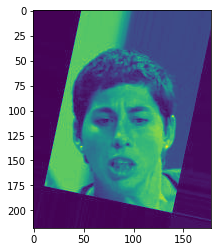

In [8]:
img_show(img_arr)

In [9]:
# load images into list/array
# images = []

num_subjects = len(data_labels_sample[1].unique())

# read images, return array
def read_image_folder(data_folder, flatten=True, grey_scale=True, open_cv=False):
    i = 0
    if open_cv == True:
        images = []
    elif flatten == True:
        images = np.zeros([len(data_labels_sample[1]), original_shape[0]*original_shape[1] ])
    else:
        images = []

    for filename in tqdm(os.listdir(data_folder)):
        if filename in sample_array[1].tolist():
            temp_img = read_img(os.path.join(data_folder, filename), flatten, grey_scale, open_cv)
            if open_cv == True:
                images.append(temp_img)
            elif flatten == True:
                images[i, :] = temp_img
            else:
                images.append(temp_img)
            i += 1
            if i >= len(data_labels_sample[1]):
                break
    return np.asarray(images)

In [10]:
image_array = read_image_folder(data_folder, flatten=False, open_cv=False)
image_array.shape

  0%|          | 0/202599 [00:00<?, ?it/s]

(1000, 218, 178)

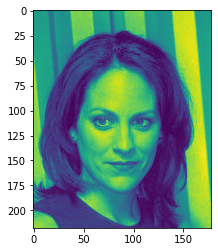

In [11]:
img_show(image_array[0])

------

In [16]:
# fisherface model by Philipp Wagner @bytefish
# https://github.com/bytefish/facerecognition_guide/tree/master/src/py/tinyfacerec

# had to do many code tweaks for it to be working for our dataset and particular problems

from tinyfacerec.subspace import fisherfaces
from tinyfacerec.util import normalize, asRowMatrix, read_images
from tinyfacerec.visual import subplot
from tinyfacerec.subspace import project, reconstruct
from tinyfacerec.model import FisherfacesModel

In [17]:
X.shape

(1000, 218, 178)

In [18]:
y.shape

(1000,)

In [88]:
[D, W, mu] = fisherfaces(asRowMatrix(X), y)

In [89]:
E = []
for i in range(min(W.shape[1], 16)):
    e = W[:,i].reshape(X[0].shape)
    E.append(normalize(e,0,255))

In [90]:
E_2 = []
for i in range(min(W.shape[1], 16)):
    e = W[:,i].reshape(-1,1)
    P = project(e, X[0].reshape(1,-1), mu)
    R = reconstruct(e, P, mu)
    # reshape and append to plots
    R = R.reshape(X[0].shape)
    E_2.append(normalize(R,0,255))

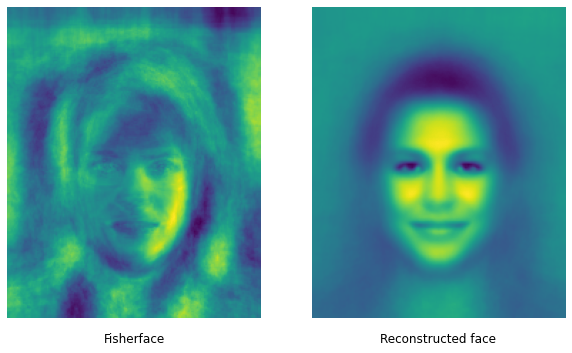

In [252]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12), )

ax1.set_axis_off()
ax1.set_title('Fisherface', y=-0.1)
ax1.imshow(np.asarray(E[0]))#, cmap=cm.gray)
ax2.set_axis_off()
ax2.set_title('Reconstructed face', y=-0.1)
ax2.imshow(np.asarray(E_2[0]))#, cmap=cm.gray)

plt.show()

In [127]:
model = FisherfacesModel(X, y, num_components=3)

In [247]:
# photo id in sample set
sample_id = 0
sample_images = data_labels_sample[data_labels_sample[1]==y[sample_id]]
sample_images.head()

,0,1
197,000198.jpg,693


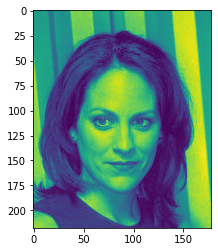

In [231]:
img_show(X[sample_id])

In [232]:
# other images outside of sample/training set
img_test = data_labels_full[(data_labels_full[1]==y[sample_id]) & (~data_labels_full[0].isin(sample_images[0].to_numpy()))]
img_test.head()

,0,1
1359,001360.jpg,693
4475,004476.jpg,693
5643,005644.jpg,693
14849,014850.jpg,693
45466,045467.jpg,693


001360.jpg


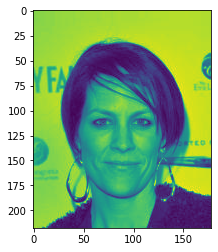

In [233]:
test_img = img_test[0].to_numpy()[0]
print(test_img)
img_arr = read_img('data/img_align_celeba/'+test_img, flatten=False, open_cv=False)
img_show(img_arr)

In [234]:
model.predict(X[sample_id])

693

In [235]:
test_img = img_test[0].to_numpy()

for item in test_img:
    img_arr = read_img('data/img_align_celeba/'+item, flatten=False, open_cv=False)
    print("Image {}. True label {}, predicted label {}, prediction {}".format(item, 
                                                               sample_images[1].values, 
                                                               model.predict(img_arr),
                                                               sample_images[1].values==model.predict(img_arr) ))

Image 001360.jpg. True label [693], predicted label 7545, prediction [False]
Image 004476.jpg. True label [693], predicted label 1882, prediction [False]
Image 005644.jpg. True label [693], predicted label 2756, prediction [False]
Image 014850.jpg. True label [693], predicted label 6726, prediction [False]
Image 045467.jpg. True label [693], predicted label 6726, prediction [False]
Image 047681.jpg. True label [693], predicted label 5999, prediction [False]
Image 055769.jpg. True label [693], predicted label 8089, prediction [False]
Image 055790.jpg. True label [693], predicted label 6826, prediction [False]
Image 056200.jpg. True label [693], predicted label 6355, prediction [False]
Image 080860.jpg. True label [693], predicted label 6059, prediction [False]
Image 081808.jpg. True label [693], predicted label 6413, prediction [False]
Image 086154.jpg. True label [693], predicted label 7102, prediction [False]
Image 089554.jpg. True label [693], predicted label 8288, prediction [False]

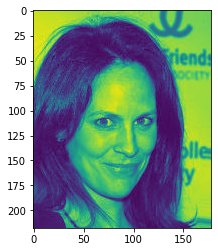

In [229]:
# 0
img_show(read_img('data/img_align_celeba/'+'108282.jpg', flatten=False, open_cv=False))

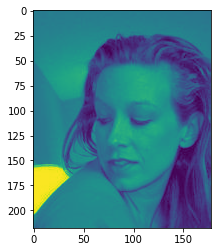

In [119]:
# 7
img_show(read_img('data/img_align_celeba/'+'097876.jpg', flatten=False, open_cv=False))

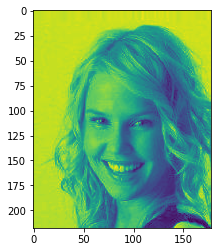

In [201]:
# 400
img_show(read_img('data/img_align_celeba/'+'016999.jpg', flatten=False, open_cv=False))

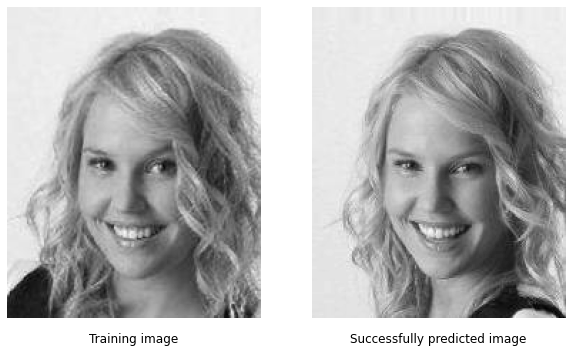

In [250]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12), )

ax1.set_axis_off()
ax1.set_title('Training image', y=-0.1)
ax1.imshow(read_img('data/img_align_celeba/'+'085076.jpg', flatten=False, open_cv=False), cmap=cm.gray)
ax2.set_axis_off()
ax2.set_title('Successfully predicted image', y=-0.1)
ax2.imshow(read_img('data/img_align_celeba/'+'016999.jpg', flatten=False, open_cv=False), cmap=cm.gray)

plt.show()

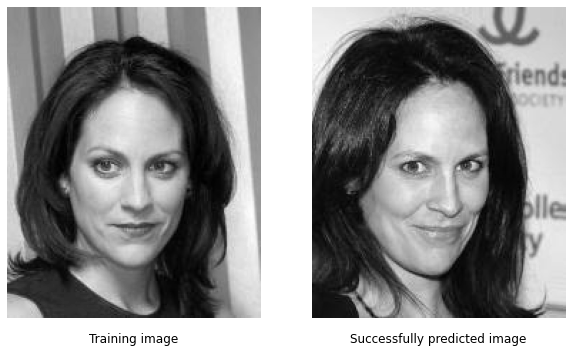

In [251]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12), )

ax1.set_axis_off()
ax1.set_title('Training image', y=-0.1)
ax1.imshow(read_img('data/img_align_celeba/'+'000198.jpg', flatten=False, open_cv=False), cmap=cm.gray)
ax2.set_axis_off()
ax2.set_title('Successfully predicted image', y=-0.1)
ax2.imshow(read_img('data/img_align_celeba/'+'108282.jpg', flatten=False, open_cv=False), cmap=cm.gray)

plt.show()